In [1]:
#模型：sentence-transformers/all-MiniLM-L6-v2
#维度：384
#优点：
#- 快
#- CPU 友好
#- 中文英文都能跑（可换中文模型）

texts = [
    "AI is transforming higher education",
    "Mental health support for college students",
    "Universities face declining enrollment",
    "Using data analytics to improve teaching",
    "Student anxiety and counseling services",
    "Workforce development and job readiness programs",
]

from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(
    texts,
    show_progress_bar=True,
    normalize_embeddings=True
)

print(embeddings.shape)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(6, 384)


In [2]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    min_samples=1,
    metric="euclidean"
)

labels = clusterer.fit_predict(embeddings)
labels

array([ 0,  1,  0,  1,  1, -1], dtype=int64)

In [3]:
import pandas as pd

df = pd.DataFrame({
    "text": texts,
    "cluster": labels
})

df


,text,cluster
0,AI is transforming higher education,0
1,Mental health support for college students,1
2,Universities face declining enrollment,0
3,Using data analytics to improve teaching,1
4,Student anxiety and counseling services,1
5,Workforce development and job readiness programs,-1


In [4]:
for c in sorted(df["cluster"].unique()):
    print(f"\n=== Cluster {c} ===")
    for t in df[df.cluster == c]["text"]:
        print("-", t)


=== Cluster -1 ===
- Workforce development and job readiness programs

=== Cluster 0 ===
- AI is transforming higher education
- Universities face declining enrollment

=== Cluster 1 ===
- Mental health support for college students
- Using data analytics to improve teaching
- Student anxiety and counseling services


In [6]:
import umap
import numpy as np

umap_model = umap.UMAP(
    n_neighbors=3,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42
)

embeddings_2d = umap_model.fit_transform(embeddings)

#文本数量	n_neighbors
#< 30	2–5
#30–100	5–10
#100+	10–30


E:\Anaconda\envs\nlp\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


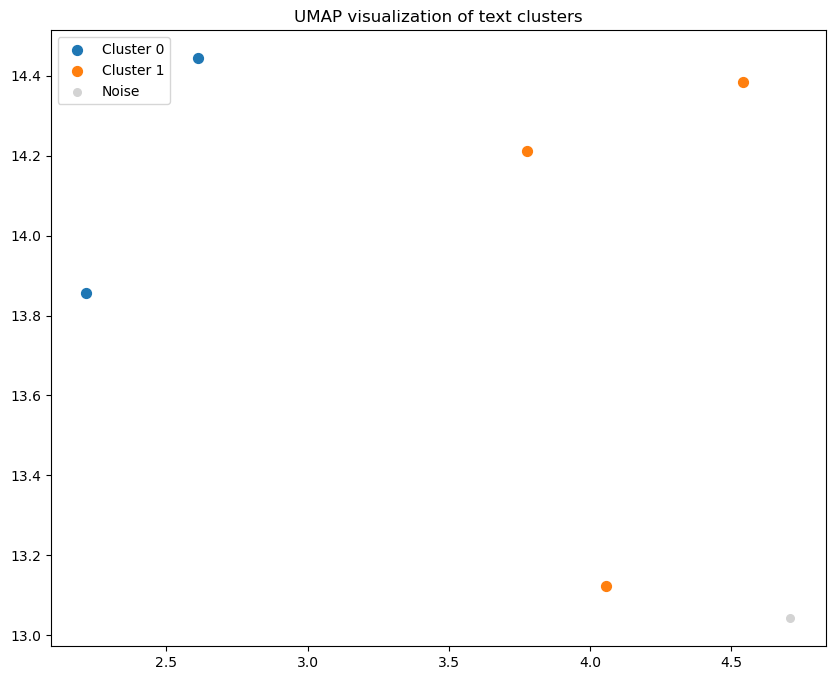

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

unique_labels = set(labels)

for label in unique_labels:
    mask = labels == label
    if label == -1:
        # 噪声点
        plt.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c="lightgray",
            s=30,
            label="Noise"
        )
    else:
        plt.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            s=50,
            label=f"Cluster {label}"
        )

plt.legend()
plt.title("UMAP visualization of text clusters")
plt.show()


In [8]:
from sklearn.metrics import silhouette_score

mask = labels != -1
score = silhouette_score(
    embeddings[mask],
    labels[mask]
)

score

#0.3+：有结构
#0.5+：很好
#0.7+：非常清晰

0.08515433222055435